In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib.colors import LogNorm
from scipy.stats import wasserstein_distance

In [2]:
sampleMap = defaultdict()
sampleMap['QCD_signal'] = {'file': '/data/shared/DiJetAnomaly/qcd_sqrtshatTeV_13TeV_PU40_SIGNALREG_concat_1M.h5'}
sampleMap['QCD_sideband'] = {'file': '/data/shared/DiJetAnomaly/qcd_sqrtshatTeV_13TeV_PU40_SIDEBAND_concat_1.3M.h5'}

featureMap = defaultdict()
featureMap['eventFeatureNames'] = ['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E',
       'DeltaEtaJJ', 'DeltaPhiJJ']
featureMap['particleFeatureNames'] = ['pEta', 'pPhi', 'pPt']


In [3]:
for sample in sampleMap:
    sampleMap[sample]['eventFeatures'] = h5py.File(sampleMap[sample]['file'],"r")['eventFeatures']
    


# Visualize stuff without any cuts

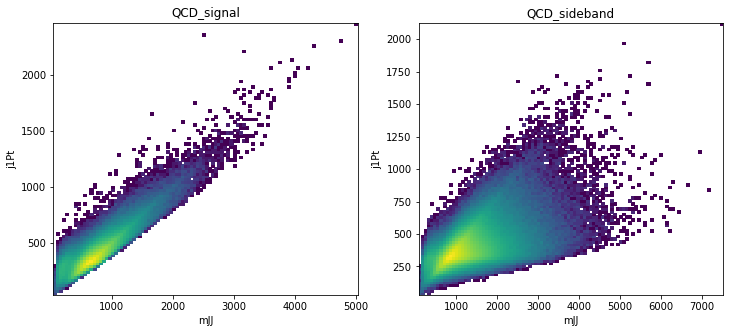

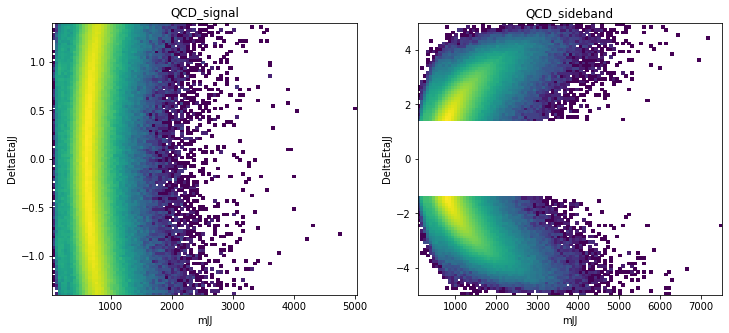

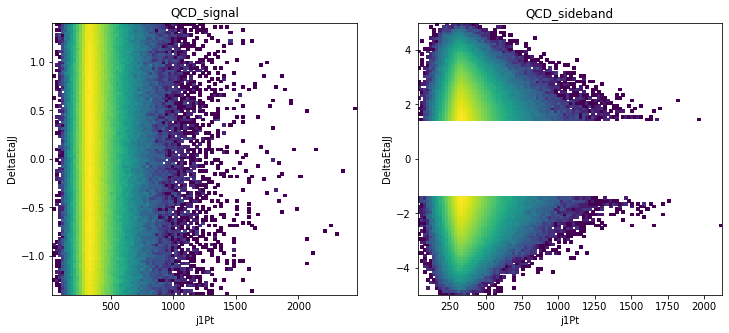

In [4]:
def getIndex(feature):
    if feature in featureMap['eventFeatureNames']: return featureMap['eventFeatureNames'].index(feature)
    if feature in featureMap['particleFeatureNames']: return featureMap['particleFeatureNames'].index(feature)
    return None
plt.figure(figsize=(12,5))
for i, sample in enumerate(sampleMap): 
    plt.subplot(1,2,i+1)
    plt.hist2d(sampleMap[sample]['eventFeatures'][:,getIndex('mJJ')], 
               sampleMap[sample]['eventFeatures'][:,getIndex('j1Pt')], 
               bins=100, norm=LogNorm())
    plt.title(sample)
    plt.xlabel('mJJ')
    plt.ylabel('j1Pt')
plt.show()

plt.figure(figsize=(12,5))
for i, sample in enumerate(sampleMap): 
    plt.subplot(1,2,i+1)
    plt.hist2d(sampleMap[sample]['eventFeatures'][:,getIndex('mJJ')], 
               sampleMap[sample]['eventFeatures'][:,getIndex('DeltaEtaJJ')], 
               bins=100, norm=LogNorm())
    plt.title(sample)
    plt.xlabel('mJJ')
    plt.ylabel('DeltaEtaJJ')
plt.show()

plt.figure(figsize=(12,5))
for i, sample in enumerate(sampleMap): 
    plt.subplot(1,2,i+1)
    plt.hist2d(sampleMap[sample]['eventFeatures'][:,getIndex('j1Pt')], 
               sampleMap[sample]['eventFeatures'][:,getIndex('DeltaEtaJJ')], 
               bins=100, norm=LogNorm())
    plt.title(sample)
    plt.xlabel('j1Pt')
    plt.ylabel('DeltaEtaJJ')
plt.show()

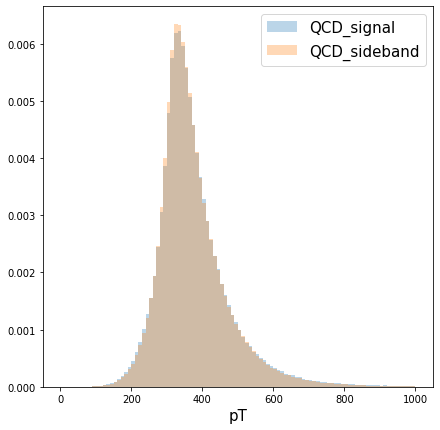

In [5]:
plt.figure(figsize=(7,7))
for i, sample in enumerate(sampleMap): 
    plt.hist(sampleMap[sample]['eventFeatures'][:,getIndex('j1Pt')], 
               bins=100, range=(0,1000), density=True, label=sample, alpha=0.3)
plt.legend(loc='best', fontsize=15)
plt.xlabel('pT', fontsize=15)
plt.show()

# Cut on mJJ > 1100 in signal and find the best threshold for sideband
Best thresholds mean smallest difference in pT distributions

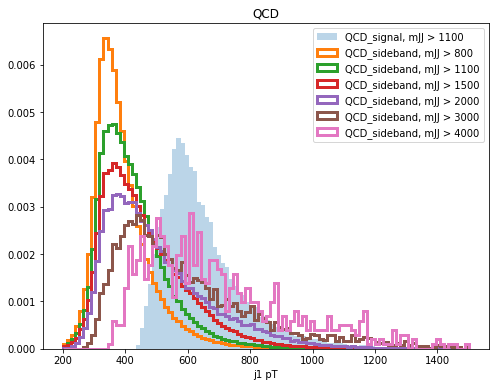

In [32]:
plt.figure(figsize=(8,6))
selected_signal = sampleMap['QCD_signal']['eventFeatures'][:, getIndex('mJJ')] > 1100
signal_pt = np.asarray(sampleMap['QCD_signal']['eventFeatures'])[selected_signal,getIndex('j1Pt')]
plt.hist(signal_pt, bins=100, range=(200,1500), density=True, label='QCD_signal, mJJ > 1100', alpha=0.3)
for cut in [800, 1100, 1500, 2000, 3000, 4000]:
    selected_sideband = sampleMap['QCD_sideband']['eventFeatures'][:, getIndex('mJJ')] > cut
    sideband_pt = np.asarray(sampleMap['QCD_sideband']['eventFeatures'])[selected_sideband,getIndex('j1Pt')]
    plt.hist(sideband_pt, bins=100, range=(200,1500), density=True, label='QCD_sideband, mJJ > {}'.format(cut), histtype='step', linewidth=3)
plt.legend(loc='best')
plt.title('QCD')
plt.xlabel('j1 pT')
plt.show()

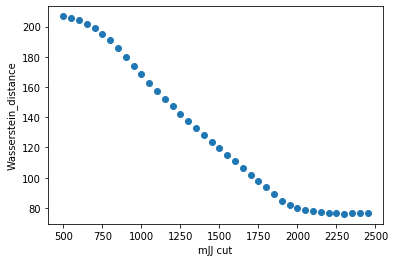

In [51]:
possible_cuts = np.arange(500, 2500, 50)
wassPt1, wassPt2 = [], []
for cut in possible_cuts:
    selected_sideband = sampleMap['QCD_sideband']['eventFeatures'][:, getIndex('mJJ')] > cut
    sideband_pt = np.asarray(sampleMap['QCD_sideband']['eventFeatures'])[selected_sideband,getIndex('j1Pt')]
    wassPt1.append(wasserstein_distance(signal_pt, sideband_pt))
plt.xlabel('mJJ cut')
plt.ylabel('Wasserstein_distance')
plt.scatter(possible_cuts, wassPt1)

# What if we decide to take the sideband to be 1 < |$\eta$| < 1.4?

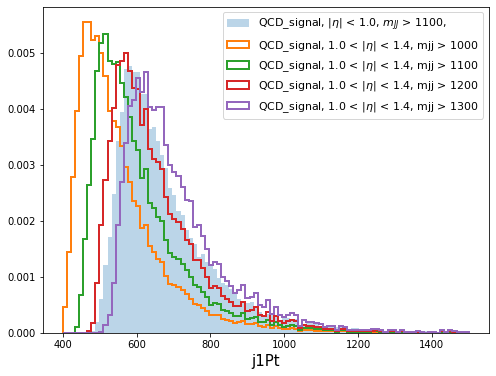

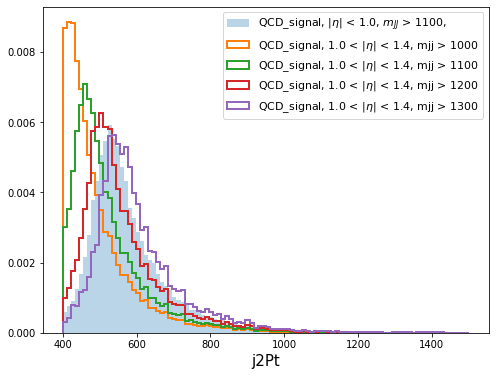

In [6]:
for jet in ['j1Pt', 'j2Pt']:
    plt.figure(figsize=(8,6))
    signal_mjj_cut = np.asarray(sampleMap['QCD_signal']['eventFeatures'][:, getIndex('mJJ')] > 1100) 
    signal_eta_cut = np.asarray(np.absolute(sampleMap['QCD_signal']['eventFeatures'][:, getIndex('DeltaEtaJJ')]) < 1)
    selected_signal = signal_mjj_cut & signal_eta_cut
    signal_pt = np.asarray(sampleMap['QCD_signal']['eventFeatures'])[selected_signal,getIndex(jet)]
    plt.hist(signal_pt, bins=100, range=(400,1500), density=True, label='QCD_signal, |$\eta$| < 1.0, $m_{JJ}$ > 1100, ', alpha=0.3)

    for mjj_cut in [1000, 1100, 1200, 1300]:
        sideband_mjj_cut = np.asarray(sampleMap['QCD_signal']['eventFeatures'][:, getIndex('mJJ')] > mjj_cut) 
        sideband_eta_cut = np.asarray(np.absolute(sampleMap['QCD_signal']['eventFeatures'][:, getIndex('DeltaEtaJJ')]) > 1)
        selected_sideband = sideband_mjj_cut & sideband_eta_cut
        sideband_pt = np.asarray(sampleMap['QCD_signal']['eventFeatures'])[selected_sideband,getIndex(jet)]
        plt.hist(sideband_pt, bins=100, range=(400,1500), density=True, 
                 label='QCD_signal, 1.0 < |$\eta$| < 1.4, mjj > {}'.format(mjj_cut), 
                 histtype='step', linewidth=2)

    plt.legend(loc='best', fontsize=11)
    plt.xlabel(jet, fontsize=15)
    plt.show()

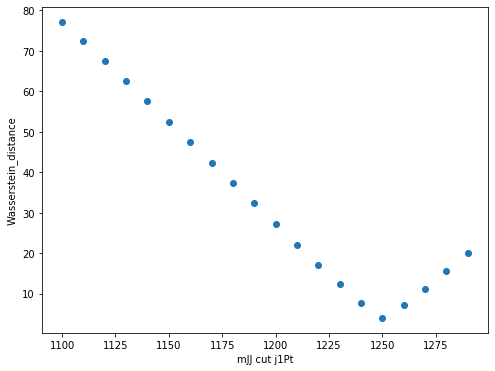

Best Wasserstein distance for j1Pt is 4.0014266898582385 at mJJ cut = 1250


In [ ]:
for jet in ['j1Pt', 'j2Pt']:
    plt.figure(figsize=(8,6))
    possible_cuts = np.arange(1100, 1300, 10)
    wassPt = []
    signal_mjj_cut = np.asarray(sampleMap['QCD_signal']['eventFeatures'][:, getIndex('mJJ')] > 1100) 
    signal_eta_cut = np.asarray(np.absolute(sampleMap['QCD_signal']['eventFeatures'][:, getIndex('DeltaEtaJJ')]) < 1)
    selected_signal = signal_mjj_cut & signal_eta_cut
    signal_pt = np.asarray(sampleMap['QCD_signal']['eventFeatures'])[selected_signal,getIndex(jet)]
    
    for cut in possible_cuts:
        sideband_mjj_cut = np.asarray(sampleMap['QCD_signal']['eventFeatures'][:, getIndex('mJJ')] > cut) 
        sideband_eta_cut = np.asarray(np.absolute(sampleMap['QCD_signal']['eventFeatures'][:, getIndex('DeltaEtaJJ')]) > 1)
        selected_sideband = sideband_mjj_cut & sideband_eta_cut
        sideband_pt = np.asarray(sampleMap['QCD_signal']['eventFeatures'])[selected_sideband,getIndex(jet)]
        
        wassPt.append(wasserstein_distance(signal_pt, sideband_pt))
    plt.xlabel('mJJ cut {}'.format(jet))
    plt.ylabel('Wasserstein_distance')
    plt.scatter(possible_cuts, wassPt)
    plt.show()
    minWass = min(wassPt)
    best_mjj = possible_cuts[np.argmin(np.asarray(wassPt))]
    print("Best Wasserstein distance for {} is {} at mJJ cut = {}".format(jet, minWass, best_mjj))